# State Space Model Book Club

In [2]:
import numpy as np
import pymc as pm
import arviz as az
import pandas as pd
import preliz as pz

import matplotlib.pyplot as plt

## Agenda

Three notebooks
1. Bayesian Basics (This one)
2. Notation
3. State Space Model Basics

## Bayes Formula

$$ \underbrace{p(\boldsymbol{\theta} \mid \boldsymbol{Y})}_{\text{posterior}} = \frac{\overbrace{p(\boldsymbol{Y} \mid \boldsymbol{\theta})}^{\text{likelihood}}; \overbrace{p(\boldsymbol{\theta})}^{\text{prior}}}{\underbrace{{{\int_{\boldsymbol{\Theta}} p(\boldsymbol{Y} \mid \boldsymbol{\theta})p(\boldsymbol{\theta}) d\boldsymbol{\theta}}}}_{\text{marginal likelihood}}} $$

## Bayesian Update Intuition

Much simpler than the formula

1. You have some prior belief
  * It may be opinionated/informmed
  * It may not

2. You get some data


3. You update your beliefs

## Simplified Bayes Formula

$$
\text{Posterior} = \frac{\text{Likelihood}  * \text{Prior}}{\text{Marginal-Likelihood}}
$$

* **Prior** - Your beliefs prior to seeing the data
* **Likelihood** - How believable the data is given a set of model parameters
* **Posterior** - Your beliefs after combining the two

* **Marginal Likelihood** - A term you need to calculate proper probabilities but in practice you largely ignore

## The typical problems Bayes 101 problems

* Coin Flips
* COVID 
* Monty Hall Problem

## Example from ProbML

<center>
  <img src="img/ProbMLCOVID.png" style="height:850px"; />
</center>

## Covid Prevalance

$$
P(SF) = \text{10%} \\
P(\text{~}SF) = \text{90%}
$$

## Likelihood of positive test

$$
P(PT | SF) = \text{Chance of a positive test given the person has space-flu.} \\
P(PT | \text{~}SF) = \text{Chance of a positive test given the person doesn’t have space flu.}
$$

$$
P(PT \mid SF) = \text{90%} \\
P(PT \mid \text{~}SF) = \text{20%}
$$

## Covid in code

In [3]:
prior = [.1, .9]  # P(SF), P(~SF)
likelihood = [.9, .2]  # P(PT | SF), p(PT | ~SF)

In [4]:
unnormalized_posterior = [None, None]
unnormalized_posterior[0] = likelihood[0]*prior[0]
unnormalized_posterior[1] = likelihood[1]*prior[1]

In [5]:
marginal_likelihood = likelihood[0]*prior[0] + likelihood[1]*prior[1]

In [6]:
posterior = [None, None]
posterior[0] = unnormalized_posterior[0] / marginal_likelihood
posterior[1] = unnormalized_posterior[1] / marginal_likelihood  
posterior

[0.33333333333333337, 0.6666666666666667]

## COVID Example Visualized

**Insert Upload to Youtube here**

## Inverse Problems

<center>
  <img src="img/InverseProblems.png" style="height:750px"; />
</center>

## We see something, what do we learn?
Not, we know something (probability values) what is the probability of some subevent occurring?

## User Conversion Probability on a website?

* A 100 visitors visit us
* 8 Convert

What do we believe about unobservable conversion rate?

## What are **possible conversion rates**?

Possible conversion rates

* 0%
* 8%
* 20%
* 31%
* 88%
* 99%

Anything between 0% and 1 % is possible

## What is the plausibility of the conversion rates?

### Lets start with priors

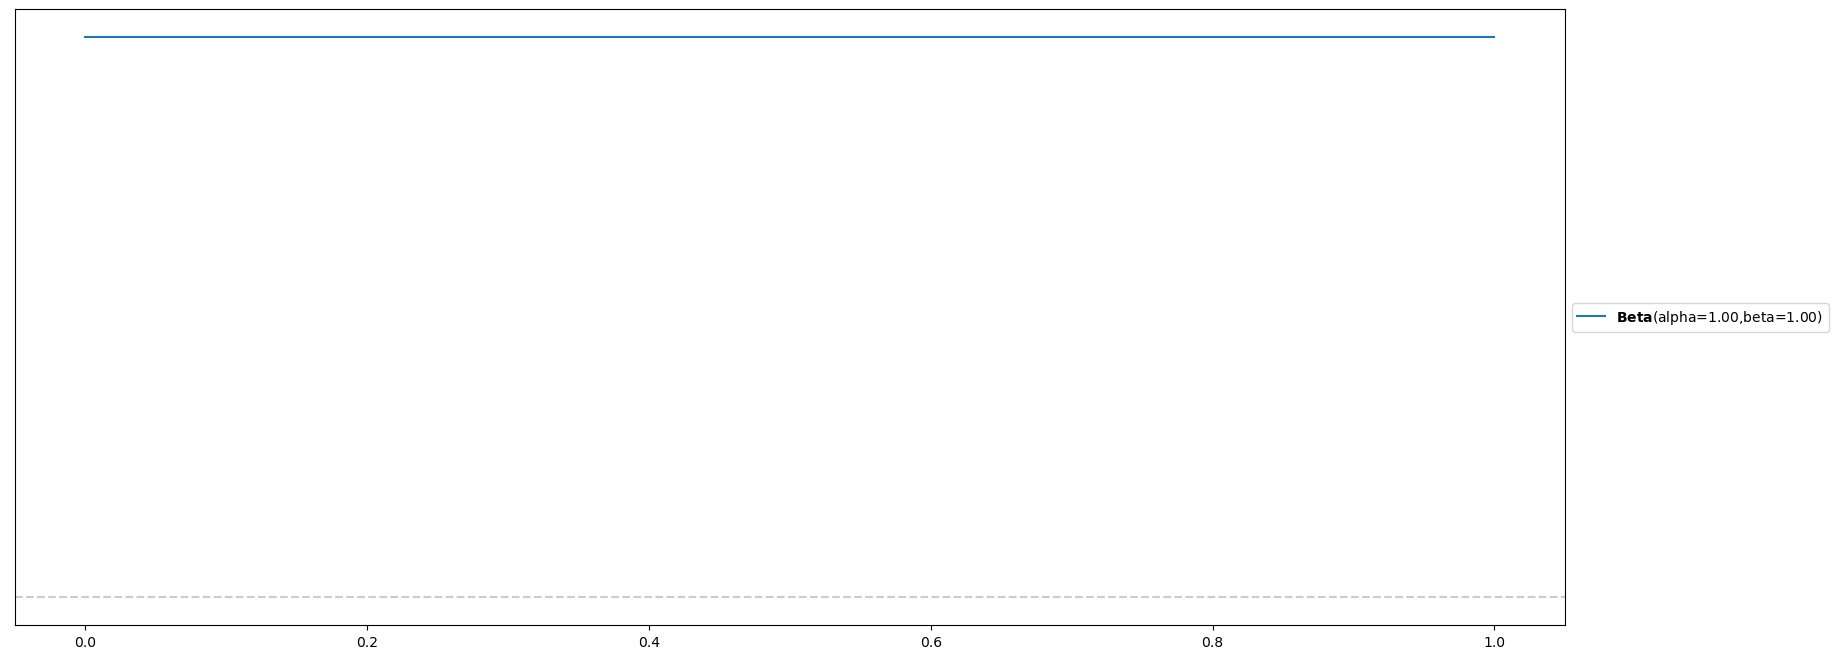

In [7]:
pz.Beta(1, 1).plot_pdf(figsize=(20,8));

## Bayesian Update

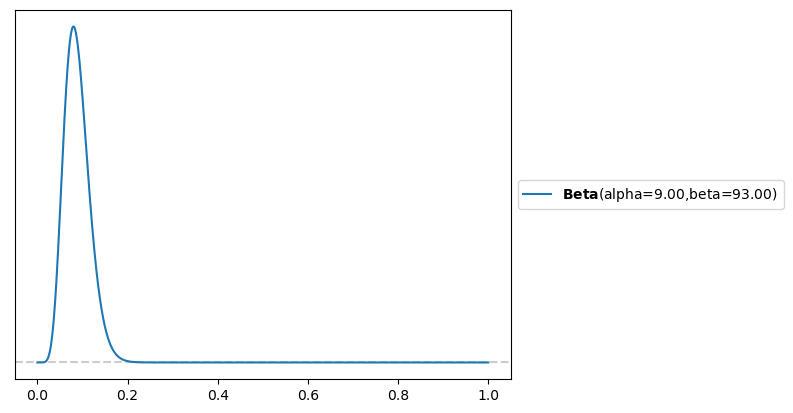

In [8]:
num_conversions = 8
num_non_conversions = 100 - num_conversions

# The bayesian update is happening right here
pz.Beta(1+num_conversions, 1+num_non_conversions).plot_pdf();

Made possible through "pen and paper" mathematics and people that are smart at math

## Relative Plausibility of all possible beliefs

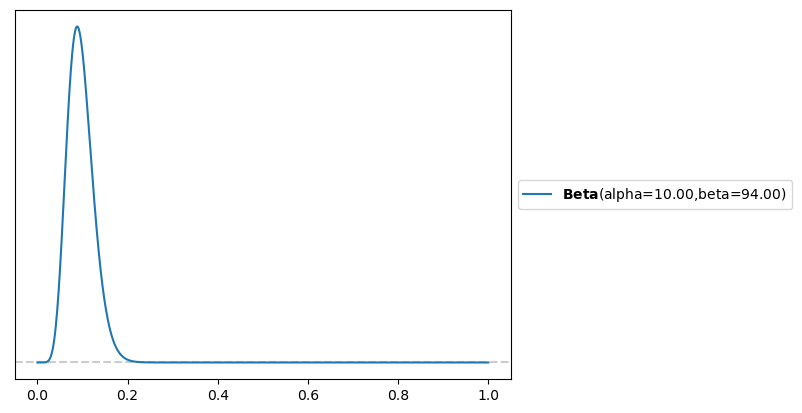

In [9]:
num_conversions = 8
num_visits = 100
num_non_conversions = num_visits - num_conversions
pz.Beta(2+8, 2+num_non_conversions).plot_pdf();

## Bayesian Update with a PPL

In [10]:
with pm.Model() as model:
    θ = pm.Beta("θ", 1, 1)
    y = pm.Binomial("y", n=num_visits, p=θ, observed=num_conversions)
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [θ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


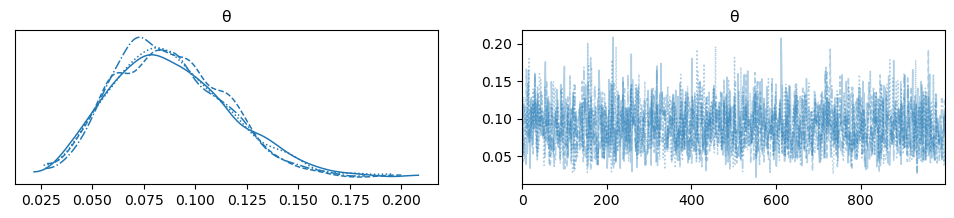

In [11]:
az.plot_trace(trace);

Made possible through computers and other people who are smart at math

## What's the difference


* Conjugate Model - Pure "pen on paper math"
  * No computer needed
  * Exact
  * Very restricted to specific prior likelihood combinations

* Markov Chain Monte Carlo algorithms
  * Not very practical without computers
  * Enables 
  * Generally applicable

## Relation to this book club

* Various SSMs have "pen and paper" solutions
* With tools like Dynamax different and more complex models may be solvable
  * Dynamax supports MCMC through blackjax so we might see this ater

We want to learn both the traditional techniques **and** what newer tools like JAX and Dynamax let us solve

## Bayesian Linear Regression of Penguins

In [12]:
penguins_url = "https://gist.githubusercontent.com/slopp/ce3b90b9168f2f921784de84fa445651/raw/4ecf3041f0ed4913e7c230758733948bc561f434/penguins.csv"
penguins = pd.read_csv(penguins_url)
# Subset to the columns needed
missing_data = penguins.isnull()[
    ["bill_length_mm", "flipper_length_mm", "sex", "body_mass_g"]
].any(axis=1)
# Drop rows with any missing data
penguins = penguins.loc[~missing_data]

adelie_mask = (penguins["species"] == "Adelie")
adelie_mass_obs = penguins.loc[adelie_mask, "body_mass_g"].values
adelie_flipper_length_obs = penguins.loc[adelie_mask, "flipper_length_mm"]


## Make a plot

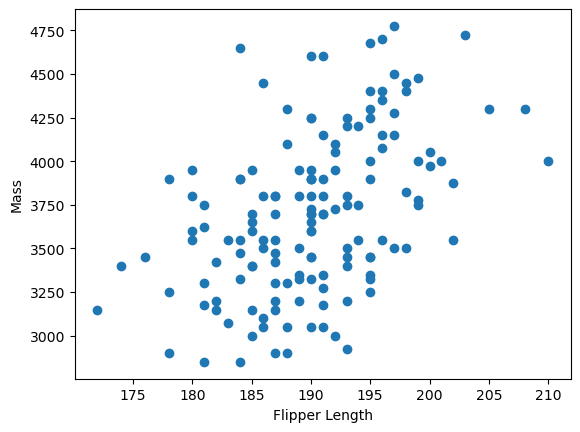

In [13]:
fig, ax = plt.subplots()


ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)
ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');

## Bayesian Regression

In [14]:

with pm.Model() as model_adelie_flipper_regression:
    # pm.Data allows us to change the underlying value in a later code block
    adelie_flipper_length = pm.Data("adelie_flipper_length",
                                    adelie_flipper_length_obs)
    σ = pm.HalfStudentT("σ", 100, 2000)
    β_0 = pm.Normal("β_0", 0, 4000)
    β_1 = pm.Normal("β_1", 0, 4000)
    μ = pm.Deterministic("μ", β_0 + β_1 * adelie_flipper_length)

    mass = pm.Normal("mass", mu=μ, sigma=σ, observed = adelie_mass_obs)

    inf_data_adelie_flipper_regression = pm.sample(return_inferencedata=True)


/Users/canyon/miniconda3/envs/ssm_book_club/lib/python3.10/site-packages/pymc/data.py:406: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, β_0, β_1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 50 seconds.


## Regression with Uncertainty bounds

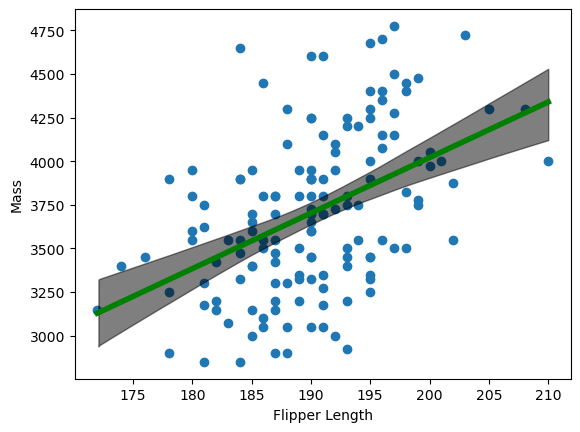

In [15]:
fig, ax = plt.subplots()
alpha_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_0"]["data"]
beta_m = inf_data_adelie_flipper_regression.posterior.mean().to_dict()["data_vars"]["β_1"]["data"]

flipper_length = np.linspace(adelie_flipper_length_obs.min(), adelie_flipper_length_obs.max(), 100)

flipper_length_mean = alpha_m + beta_m * flipper_length
ax.plot(flipper_length, flipper_length_mean, c='g', lw=4,
         label=f'y = {alpha_m:.2f} + {beta_m:.2f} * x')

ax.scatter(adelie_flipper_length_obs, adelie_mass_obs)

# Figure out how to do this from inference data
az.plot_hdi(adelie_flipper_length_obs, inf_data_adelie_flipper_regression.posterior['μ'], hdi_prob=0.94, color='k', ax=ax)

ax.set_xlabel('Flipper Length')
ax.set_ylabel('Mass');

## Dynamax Book Club Takeaway

* Bayes theorem is a philosophy for how we can update our beliefs given observations
* ProbML calls outcome -> belief mapping inverse probability
* What we care about is the relative plausibiilty
* For the same model there can be different estimators
  * Each as their tradeoffs
  * Computer enables newer ones not possible in the past